In [28]:
import tensorflow as tf
import numpy as np

In [29]:
class InnerProductLayer(tf.keras.layers.Layer):
    """
    该layer为根据embedding矩阵的输入计算paper中的l_p向量
    内积
    """
    def __init__(self,n,field_num,*args,**kwargs):
        """

        :param n: int 指L_p的维度
        :param field_num: int 指特征中有多少个field，例如如果输入有性别类型、年龄段，那么field就是2
        :param args:
        :param kwargs:
        """
        super(InnerProductLayer,self).__init__(*args,**kwargs)
        self.n=n
        self.field_num=field_num

    def build(self, input_shape):
        self.W=tf.Variable(tf.random.truncated_normal(shape=[1,self.n,self.field_num,self.field_num]))

    def call(self, z,**kwargs):
        """

        :param z: tensor shape:[batch_size,field_num,emb_dim]
        :return:
        """
        z=tf.expand_dims(z,axis=1) # [batch_size,1,field_num,emb_dim]
        transpose_z=tf.transpose(z,perm=[0,1,3,2])  # [batch_size,1,emb_dim,field_num]

        P=tf.matmul(z,transpose_z) # [batch_size,1,field_num,field_num] 对每个样本来说，他的嵌入向量矩阵为[field_num,emb_dim]，对其求内积
        L_P=self.W*P # [batch_size,n,field_num,field_num] 然后做线性变换
        L_P=tf.reduce_sum(L_P,axis=[2,3]) # [batch_size,n]
        return L_P

inputs=np.random.random(size=[5,6,3]).astype(np.float32)
inner_layer=InnerProductLayer(4,field_num=6)

inner_layer(inputs)


<tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[-0.65198624, -0.03794616, -7.187478  , -5.5731344 ],
       [-1.2265905 ,  4.4830847 , -1.8777007 , -4.1318626 ],
       [-0.46637058,  5.0796943 , -4.8526483 , -7.663569  ],
       [-2.0159469 ,  4.9497485 , -1.9350233 , -3.7257738 ],
       [ 4.3615103 ,  3.9359689 , -6.9412    , -7.4221873 ]],
      dtype=float32)>

In [30]:
class OuterProductLayer(tf.keras.layers.Layer):
    """
    外积
    """
    def __init__(self,n,emb_dim,*args,**kwargs):
        super(OuterProductLayer,self).__init__(*args,**kwargs)
        self.n=n
        self.emb_dim=emb_dim

    def build(self, input_shape):
        self.W=tf.Variable(tf.random.truncated_normal(shape=[1,self.n,self.emb_dim,self.emb_dim]))

    def call(self, z, **kwargs):
        """

        :param z: tensor shape:[batch_size,field_num,emb_dim]
        :return:
        """
        # 计算方法就是paper中说的，没啥好谈的
        f_sum=tf.expand_dims(tf.reduce_sum(z,axis=1),axis=2) # [batch_size,emb_dim,1]
        transpose_f_sum=tf.transpose(f_sum,perm=[0,2,1])  # [batch_size,emb_dim,1]
        P=tf.expand_dims(tf.matmul(transpose_f_sum,f_sum),axis=1) # [batch_size,1,emb_dim,emb_dim]
        L_P=self.W*P # [batch_size,n,emb_dim,emb_dim]
        L_P=tf.reduce_sum(L_P,axis=[2,3])
        return L_P

inputs=np.random.random(size=[5,6,3]).astype(np.float32)
outer_layer=OuterProductLayer(4,emb_dim=3)

outer_layer(inputs)

<tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[80.45505   , -6.2753916 ,  1.2577846 , 66.489136  ],
       [89.01259   , -6.9428635 ,  1.3915672 , 73.5612    ],
       [49.69133   , -3.8758612 ,  0.7768446 , 41.06559   ],
       [64.91035   , -5.0629253 ,  1.014766  , 53.642796  ],
       [55.711075  , -4.345395  ,  0.87095094, 46.040386  ]],
      dtype=float32)>

In [31]:
class LzLayer(tf.keras.layers.Layer):
    def __init__(self,n,field_num,emb_dim,*args,**kwargs):
        super(LzLayer,self).__init__(*args,**kwargs)
        self.n=n
        self.field_num=field_num
        self.emb_dim=emb_dim

    def build(self, input_shape):
        self.W=tf.Variable(tf.random.truncated_normal(shape=[1,self.n,self.field_num,self.emb_dim]))

    def call(self, z, **kwargs):
        """

        :param z: tensor shape:[batch_size,field_num,emb_dim]
        :param kwargs:
        :return:
        """
        z=tf.expand_dims(z,axis=1) # [batch_size,1,field_num,emb_dim]
        L_Z=z*self.W # [batch_size,n,field_num,emb_dim]
        L_Z=tf.reduce_sum(L_Z,axis=[2,3]) # [batch_size,n]

        return L_Z
inputs=np.random.random(size=[5,6,3]).astype(np.float32)
lz_layer=LzLayer(4,field_num=6,emb_dim=3)

lz_layer(inputs)


<tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[ 2.5931726e+00,  4.7880135e+00,  1.0537939e+00, -1.9670380e+00],
       [ 2.1209812e+00,  2.7907205e+00,  1.4050236e+00, -1.6423281e+00],
       [ 4.1271615e+00,  1.8490990e+00, -2.7216673e-03, -3.6297574e+00],
       [ 1.4559181e+00,  1.3751614e+00,  1.4929209e+00, -9.7928894e-01],
       [ 3.1647882e+00,  4.2719307e+00,  2.1074181e+00, -1.1484994e+00]],
      dtype=float32)>

In [32]:
class ProductNeuralNetworksModel(tf.keras.Model):
    def __init__(self,input_dims,emb_dim,dense_units,d1,product_type="inner",scoring_layer_units=2,*args,**kwargs):
        """

        :param input_dims: [int] 各个field的embedding layer的input_dim，代表某个field的特征有多少个不同的取值
        :param emb_dim: int 嵌入向量的维度
        :param dense_units:
        :param d1: int paper中的l1层的输入维度，指的是paper中的D_1
        :param product_type: str inner or outer
        :param args:
        :param kwargs:
        """
        super(ProductNeuralNetworksModel,self).__init__(*args,**kwargs)
        self.emb_layers=list()
        self.field_num=len(input_dims)
        self.emb_dim=emb_dim
        for input_dim in input_dims:
            self.emb_layers.append(tf.keras.layers.Embedding(input_dim=input_dim,output_dim=emb_dim))
        self.lz_layer=LzLayer(n=d1,field_num=self.field_num,emb_dim=self.emb_dim)
        if product_type=="inner":
            self.product_layer=InnerProductLayer(n=d1,field_num=self.field_num)
        elif product_type=="outer":
            self.product_layer=OuterProductLayer(n=d1,emb_dim=self.emb_dim)
        else:
            raise ValueError()

        self.b1=tf.Variable(tf.zeros(shape=[d1]))
        self.dense_layer=tf.keras.layers.Dense(dense_units)
        self.scoring_layer=tf.keras.layers.Dense(scoring_layer_units,activation=None)

    def call(self, inputs, training=None, mask=None):
        """

        :param inputs: tensor ,shape :[batch_size, len(self.input_dims)]
        :param training:
        :param mask:
        :return:
        """
        emb_vecs=list()
        for i,emb_layer in enumerate(self.emb_layers):
            emb_vecs.append(emb_layer(inputs[:,i]))

        # emb_vecs里每一个元素都是(batch_size, emb_dim)
        z=tf.stack(emb_vecs,axis=1) # shape :[batch_size, field_num, emb_dim]
        l_z=self.lz_layer(z)
        l_p=self.product_layer(z)

        l1=l_z+l_p+self.b1
        l1=tf.nn.relu(l1)
        l2=self.dense_layer(l1)
        y=self.scoring_layer(l2)
        return y

input_arr=np.random.randint(0,5,size=[5,3])
pnn_model=ProductNeuralNetworksModel([5,5,5],emb_dim=2,dense_units=2,d1=3,product_type="inner")
pnn_model(input_arr)


<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[0.5       , 0.5       ],
       [0.50260067, 0.50554425],
       [0.50199586, 0.50036293],
       [0.50183463, 0.500886  ],
       [0.50113255, 0.5024145 ]], dtype=float32)>

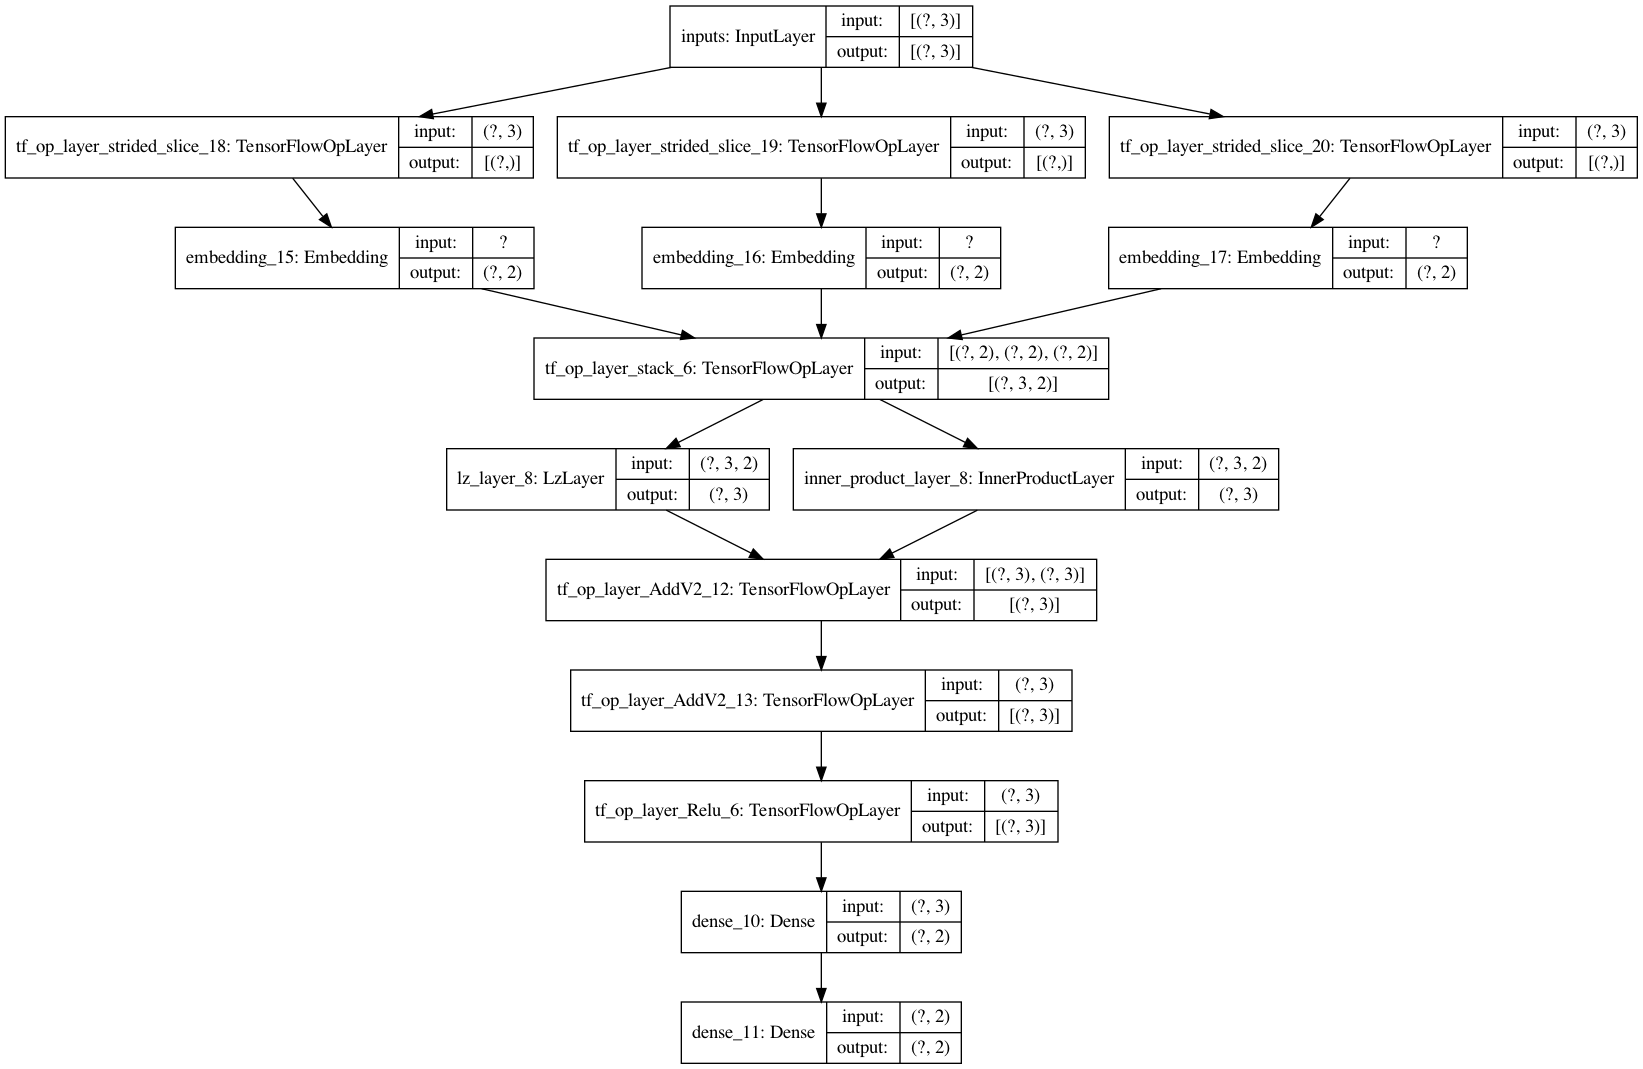

In [38]:
# 画流程图 需要pip install pydot，并且本机安装graphviz
# 注意，这个玩意只能去plot Sequencial或者下面这样，得手动调用model的call，才能画出来
# 直接output=model(inputs)也不行

inputs=tf.keras.Input(shape=(3), dtype=tf.float32, name='inputs') # 里面的3指的是一个样本的维度
outputs=pnn_model.call(inputs)
pnn_model_for_plot=tf.keras.Model(inputs=inputs,outputs=outputs)
pnn_model_for_plot.compile()
tf.keras.utils.plot_model(pnn_model_for_plot,to_file="model.png", show_shapes=True,expand_nested=True)
